# Planet Labs Kaggle Competition

https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/submit

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from planet import *
from IPython.display import Audio

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [23]:
Audio('./done.mp3', autoplay=True)

In [5]:
torch.cuda.set_device(0)

In [6]:
PATH = Path("data/planet")
sz = 224
arch = resnet34
bs = 58

In [7]:
label_csv = PATH/"train_v2.csv"
n = len(list(open(label_csv))) - 1
validation_idxs = get_cv_idxs(n) # default - save 20% for validation

In [8]:
!ls {PATH}

models			  test-jpg-irgb		    train-jpg-irgb
play			  test-tif-v2		    train-tif-v2
sample_submission_v2.csv  test_v2_file_mapping.csv  train_v2.csv
test-jpg		  tmp
test-jpg-additional	  train-jpg


In [9]:
label_df = pd.read_csv(label_csv)

In [10]:
label_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [11]:
# how to group on individual tags instead of combination?
# label_df.pivot_table(index='tags', aggfunc=len).sort_values('image_name', ascending=False)

# Data augmentation

In [12]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 
                                    folder='train-jpg-irgb', 
                                    test_name='test-jpg-irgb',
                                    val_idxs=validation_idxs,
                                    csv_fname=label_csv, 
                                    bs=bs, 
                                    tfms=tfms, 
                                    suffix='.jpg')
    return data

In [13]:
data=get_data(sz, bs)

In [14]:
learn = ConvLearner.pretrained(arch, data, metrics=[f2])

In [22]:
data.classes

['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

In [36]:
i = 99
fn = PATH/data.trn_ds.fnames[i]; print(fn)
cl = data.trn_ds.get_y(i); 
print(np.array(data.classes)[np.where(cl)[0]])

data/planet/train-jpg-irgb/train_123.jpg
['agriculture' 'bare_ground' 'clear' 'habitation' 'primary' 'road']


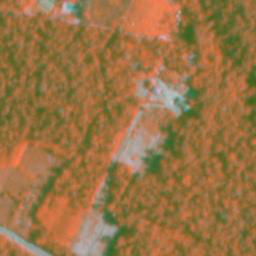

In [37]:
img = PIL.Image.open(fn).convert('RGB'); img

In [38]:
img.size

(256, 256)

# Find learning rate

In [ ]:
lrf = learn.lr_find()

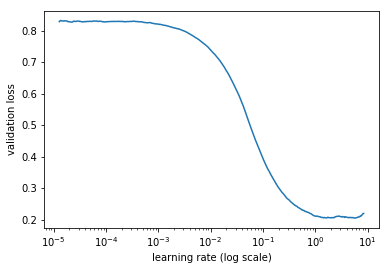

In [31]:
learn.sched.plot()

In [15]:
lr = 0.2

# Train on small images

In [41]:
data = get_data(64, bs)
learn = ConvLearner.pretrained(arch, data, metrics=[f2])

In [42]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.157188   0.146561   0.86751   
    1      0.153785   0.141882   0.871328                    
    2      0.150428   0.139509   0.876136                    
    3      0.154333   0.140626   0.874645                    
    4      0.146471   0.137503   0.876706                    
    5      0.145332   0.136804   0.877581                    
    6      0.145741   0.135866   0.879138                    


[array([0.13587]), 0.8791381609769876]

In [48]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.145494   0.135707   0.879191  
    1      0.14684    0.136248   0.877859                    
    2      0.143395   0.134515   0.880578                    


[array([0.13451]), 0.8805782650083231]

In [49]:
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   f2                          
    0      0.149483   0.13441    0.880678  
    1      0.145731   0.134282   0.881479                    
    2      0.141752   0.134432   0.880897                    


[array([0.13443]), 0.8808971906052829]

In [16]:
#learn.save('planet-irgb-64-frozen');
learn.load('planet-irgb-64-frozen');

# Unfreeze to train earlier layers

In [17]:
lrs = [lr/4, lr/2, lr]
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.121329   0.109936   0.907271  
    1      0.119249   0.108157   0.908114                    
    2      0.108008   0.103354   0.91309                     
    3      0.118635   0.106332   0.908243                    
    4      0.109889   0.103145   0.914067                    
    5      0.105458   0.100456   0.915101                    
    6      0.098789   0.100159   0.916204                     



[array([0.10016]), 0.9162042328112693]

In [21]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                           
    0      0.104171   0.100071   0.916439  
    1      0.107767   0.101565   0.91341                     
    2      0.098922   0.099567   0.916957                     
    3      0.106233   0.105063   0.910675                    
    4      0.10162    0.100632   0.915609                     
    5      0.093267   0.099663   0.917269                     
    6      0.097172   0.098837   0.917829                     


[array([0.09884]), 0.9178290852925669]

In [27]:
#learn.save('planet-irgb-64-unfrozen');
learn.load('planet-irgb-64-unfrozen');

# Train on larger data

In [28]:
learn.set_data(get_data(128, bs))

learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.110547   0.109293   0.906807  
    1      0.110567   0.108687   0.907866                    
    2      0.106612   0.1079     0.908636                    
    3      0.105683   0.108576   0.907856                    
    4      0.107709   0.107866   0.909075                    
    5      0.105518   0.107408   0.908402                    
    6      0.10782    0.10733    0.908981                    


[array([0.10733]), 0.9089806684656954]

In [29]:
learn.unfreeze()
lrs = [lr/3, lr/1.5, lr]
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.108952   0.103734   0.911942  
    1      0.111166   0.104427   0.913675                    
    2      0.10163    0.102691   0.91305                      
    3      0.109152   0.108441   0.907968                    
    4      0.10329    0.103545   0.912647                    
    5      0.096958   0.101287   0.915132                     
    6      0.095255   0.100823   0.915689                     


[array([0.10082]), 0.9156890024542084]

In [30]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                           
    0      0.097457   0.101593   0.914574  
    1      0.102104   0.105431   0.910473                    
    2      0.094265   0.10135    0.915366                     
    3      0.106155   0.103518   0.912545                     
    4      0.099307   0.104819   0.911122                     
    5      0.09325    0.101613   0.914428                     
    6      0.090043   0.101521   0.91562                      


[array([0.10152]), 0.9156204927690614]

In [31]:
learn.save('128-frozen');
learn.load('128-frozen');

In [ ]:
learn.set_data(get_data(256, bs))

learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.10735    0.10599    0.910721  
    1      0.106002   0.105053   0.912047                    
    2      0.10456    0.1046     0.911944                    
    3      0.103929   0.103996   0.913398                    
    4      0.104503   0.103566   0.912532                     
 49%|████▉     | 276/559 [02:04<02:03,  2.30it/s, loss=0.105]